# 2. Sentiment Analysis using Neural Network

In class, we learned sequence representation and how language models are developed for different tasks. In this assignment, we will implement two neural network models for sentiment analysis task using IMDB dataset. Sentiment analysis in Natural Language Processing (NLP) is a task that involves classifying sentences or text into different categories based on the sentiment expressed. It aims to determine whether the sentiment of the text is positive, or negative. This analysis helps in understanding the overall opinion or emotion conveyed by the text.

Please note that this assignment is built and tested under *Google Colaboratory*. If you work on a local machine, you need to handle version issue on your own. Please complete the given jupyter notebook file and submit it along with your answer to this latex file.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## Data Preprocessing

In this assignment, we will use TorchText package to deal with the data. There are a few ways to process the data, but this package makes this procedure much easier. Now we will go over the next steps with TorchText:

- Preprocessing
- Split into train and test set
- Build dataset
- Building vocabulary
- Batching the data

Once you load the data, there will be two columns, review comment and sentiment label (1 for positive and 0 for negative).
Out of 50000 sample data, we will use 30000 as our training set and rest of the data as our test set.
You can refer to [here](https://torchtext.readthedocs.io/en/latest/index.html) for more information on the TorchText.

In [ ]:
!pip install torchtext==0.6.0

In [ ]:
import urllib.request
import pandas as pd
from torchtext import data, datasets
from torchtext.vocab import Vocab
from torchtext.data import TabularDataset
from torchtext.data import Iterator


In [ ]:
# load data
urllib.request.urlretrieve("https://raw.githubusercontent.com/LawrenceDuan/IMDb-Review-Analysis/master/IMDb_Reviews.csv", filename="IMDb_Reviews.csv")


In [ ]:
df = pd.read_csv('IMDb_Reviews.csv', encoding='latin1')
df.head()

In [ ]:
print('Total number of sample data: {}'.format(len(df)))

In [ ]:
train_df = df[:30000]
test_df = df[30000:]

train_df.to_csv("train_data.csv", index=False)
test_df.to_csv("test_data.csv", index=False)

In [ ]:
# data preprocessing
TEXT = data.Field(sequential=True,
                  use_vocab=True,
                  tokenize=str.split,
                  lower=True,
                  batch_first=True,
                  fix_length=100)

LABEL = data.Field(sequential=False,
                   use_vocab=False,
                   batch_first=False,
                   is_target=True)

In [ ]:
# build dataset
train_data, test_data = TabularDataset.splits(
        path='.', train='train_data.csv', test='test_data.csv', format='csv',
        fields=[('text', TEXT), ('label', LABEL)], skip_header=True)

In [ ]:
print('number of training data : {}'.format(len(train_data)))
print('number of test data : {}'.format(len(test_data)))

In [ ]:
print(train_data.fields.items())

In [ ]:
print(train_data[0].text)
print(train_data[0].label)

In [ ]:
print(vars(train_data[0]))

In [ ]:
# build vocabulary
TEXT.build_vocab(train_data, min_freq=10, max_size=10000)

In [ ]:
print('size of the vocabulary : {}'.format(len(TEXT.vocab))) # includes <unk> and <pad>

In [ ]:
print(TEXT.vocab.stoi)

In [ ]:
# build data loader and batching the data
batch_size = 64
train_loader = Iterator(dataset=train_data, batch_size = batch_size)
test_loader = Iterator(dataset=test_data, batch_size = batch_size)

In [ ]:
print('number of mini-batches for training data : {}'.format(len(train_loader)))
print('number of mini-batches for test data : {}'.format(len(test_loader)))

In [ ]:
batch = next(iter(train_loader))
print(type(batch))

In [ ]:
print(batch.text)

In [ ]:
print(batch.label)

## Problem 2-1. Multilayer Perceptron (MLP) (30 pts)

In this question, we are going to implement a simple Multilayer Perceptron (MLP) model to classify IMDB dataset. MLP is the classical type of neural network, and they are comprised of one or more layers of neurons. Data is fed to the input layer, there may be one or more hidden layers providing levels of abstraction, and predictions will be made on the output layer.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

### Problem 2-1 (a) (10 pts)

Implement a two-layer fully-connected neural network. Your model should contain an embedding layer to represent a word in a dense vector representation. Use ReLU for activation function.

In [ ]:
class Linear(nn.Module):
    def __init__(self, input_size, hidden_size, embed_dim, num_classes):
        super(Linear, self).__init__()
        #################### YOUR CODE (3 lines) #####################
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, num_classes)
        self.embed = nn.Embedding(embed_dim, input_size)

        ###############################################################

    def forward(self, text):
        #################### YOUR CODE (3-5 lines) #####################
        # hint: you can use F.relu and F.softmax
        embedded = self.embed(text)
        embedded = embedded.view(embedded.size(0), -1)  # flatten the embedding
        hidden = F.relu(self.fc1(embedded))
        preds = self.fc2(hidden)
        preds = F.softmax(preds, dim=1)  # apply softmax to the output


        ###############################################################
        return preds

### Problem 2-1 (b) (10 pts)

Implement a function to check the accuracy of your model.

In [ ]:
def model_accuracy(output, target):
    #################### YOUR CODE (2-3 lines) #####################
    _, predicted = torch.max(output, 1)  # get the index of the max log-probability
    correct = (predicted == target).sum().item()  # count correct predictions
    accuracy = correct / target.size(0)  # calculate accuracy as a fraction of correct


    ###############################################################
    return accuracy

### Problem 2-1 (c) (5 pts)

Complete the code below to train the model

In [ ]:
def train(model, iterator, optimizer, criterion):

    loss_ep = 0
    acc_ep = 0

    for batch in iterator:
        optimizer.zero_grad()

        #################### YOUR CODE (1-2 lines) #####################
        output = model(batch.text)

        ###############################################################
        loss = criterion(output, batch.label.squeeze())
        acc = model_accuracy(output, batch.label)

        loss.backward()
        optimizer.step()

        loss_ep += loss.item()
        acc_ep += acc.item()

    return loss_ep / len(iterator), acc_ep / len(iterator)

### Problem 2-1 (d) (5 pts)

Complete the code below to evaluate the model

In [ ]:
def evaluate(model, iterator, criterion):

    loss_ep = 0
    acc_ep = 0

    model.eval()
    with torch.no_grad():
        for batch in iterator:
            #################### YOUR CODE (1-2 lines) #####################
            output = model(batch.text)

            ###############################################################
            loss = criterion(output, batch.label)
            acc = model_accuracy(output, batch.label)

            loss_ep += loss.item()
            acc_ep += acc.item()

    return loss_ep / len(iterator), acc_ep / len(iterator)

Now let's see the model performance

In [ ]:
def train_the_model(epochs, model, train_loader, valid_loader, optimizer, criterion):

    for epoch in range(epochs):

        train_loss, train_acc = train(model, train_loader, optimizer, criterion)
        valid_loss, valid_acc = evaluate(model, valid_loader, criterion)

        print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc * 100:.2f}%')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc * 100:.2f}%')

    torch.save(model.state_dict(), 'saved_weights_linear.pt')

In [ ]:
# hyperparameter
num_epochs = 10
lr = 1e-4
max_token_length = 100
hidden_size = 100
embed_dim = 100
seed = 1
num_classes = 2

In [ ]:
loss_function = nn.CrossEntropyLoss()
linear_model = Linear(max_token_length, hidden_size, embed_dim, num_classes)
optimizer = torch.optim.Adam(linear_model.parameters(), lr=lr)

train_the_model(num_epochs, linear_model, train_loader, test_loader, optimizer, loss_function)


## Problem 2-2. Convolutional Neural Network (CNN) (20 pts)

Next, we will perform sentimental analysis on the same dataset with Convolutional Neural Network (CNN). In a CNN, text is organised into a matrix, with each row representing a word embedding. The CNN’s convolutional layer scans the text like it would an image, breaks it down into features, and judges whether each feature matches the relevant label or not.
You can refer to [here](https://emnlp2014.org/papers/pdf/EMNLP2014181.pdf) for the use of CNN on text classification.


### Problem 2-2 (a) (15 pts)

Complete the code below for CNN. Again, your model will require an embedding layer to represent into dense vector. After getting embeddings, we will feed the tensors through the convolutional layer, applying the ReLu activation function following the convlutional layers. Then the tensors will be passed through pooling layers. Lastly, apply dropout to the concatenated filter outputs and subsequently pass them through a linear layer to *generate* our predictions.

In [ ]:
class CNN(nn.Module):
    def __init__(self, input_dim, embed_dim, n_filters, filter_sizes, num_classes, dropout_rate):
        super().__init__()

        self.embedding = nn.Embedding(input_dim, embed_dim)
        # convolutions with different size of filters
        self.convs = nn.ModuleList([nn.Conv2d(in_channels=1,
                                              out_channels=n_filters,
                                              kernel_size=(filter_size, embed_dim))
                                    for filter_size in filter_sizes])

        self.fc = nn.Linear(len(filter_sizes)*n_filters, num_classes)
        self.dropout = nn.Dropout(dropout_rate)


    def forward(self, text):
        # text = [batch_size, sen_len]

        embedded = self.embedding(text)
        # embedded = [batch_size, sen_len, embed_dim]

        embedded = embedded.unsqueeze(1)
        # embedded = [batch_size, 1, sen_len, embed_dim]

        #################### YOUR CODE (4 lines) #####################
        # hint: you can use F.relu, F.max_pool1d, and torch.cat
        conved = [F.relu(conv(embedded)).squeeze(3) for conv in self.convs]
        # conved = [batch_size, n_filters, sen_len - filter_sizes[n] + 1] for n in filter_sizes]

        # After getting embeddings, we will feed the tensors through the convolutional layer, applying the ReLu activation function following the convlutional layers.
        # output size of the n-convolutional layer = [batch_size, n_filters, sen_len - filter_sizes[n] + 1]
        pooled = [F.max_pool1d(c, c.size(2)).squeeze(2) for c in conved]
        # pooled = [batch_size, n_filters] for n in filter_sizes

        # Then the tensors will be passed through pooling layers.
        # output size of the n-pooling layer = [batch_size, n_filters]
        output = torch.cat(pooled, dim=1)
        # output = [batch_size, n_filters * len(filter_sizes)]

        # Lastly, apply dropout to the concatenated filter outputs and subsequently pass them through a linear layer to generate our predictions.
        # output size of the dropout = [batch size, n_filters * len(filter_sizes)]
        output = self.dropout(output)
        # output = [batch_size, n_filters * len(filter_sizes)]




        ###############################################################
        return output

Now let's see the model performance.

We will use the same function that we used in MLP model for model training and evaluation.
It will take about 30 minutes to run 5 epochs

In [ ]:
# hyperparameter
num_epochs = 5
lr = 1e-4
input_dim = len(TEXT.vocab)
embed_dim = 300
num_filters = 100
filter_sizes = [3,5,7]
dropout_rate = 0.25
num_classes = 2

In [ ]:
cnn_model = CNN(input_dim, embed_dim, num_filters, filter_sizes, num_classes, dropout_rate)

optimizer = torch.optim.Adam(cnn_model.parameters(), lr=lr)
train_the_model(num_epochs, cnn_model, train_loader, test_loader, optimizer, loss_function)


### Problem 2-2 (b) (5 pts)

Compare the linear model (problem 1) and CNN (problem 2), and discuss their advantages and limitations.

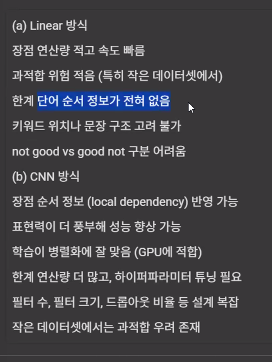